In [1]:
##from https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/
##     https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

In [2]:
import os, string
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
from keras import callbacks
from keras.models import Sequential, model_from_yaml, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.utils import np_utils, plot_model
##from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from keras.applications.resnet50 import preprocess_input, decode_predictions

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal as sg
from PIL import Image
import numpy as np
np.random.seed(10)

Using TensorFlow backend.
/home/ccw88u/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config=config))

In [4]:
from numpy import array
from pickle import load
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu

from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input


from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions


In [5]:
#img_w, img_h = 224, 224

In [6]:
#圖片變向量
def imgfile2arr(fname):
    return np.asarray(Image.open(fname).convert('L'), dtype=np.float32)
def img2array(img):
    return np.asarray(img, dtype=np.float32)
#向量轉圖片
def arr2img(arr):
    return Image.fromarray(np.clip(arr,0,255).round().astype(np.uint8)).convert('L')
#讀取圖檔尺寸 & 看圖檔
def read_img_manview(filepath, shapearg=1, imgshowarg=1):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg    
    import os
    if os.path.isfile(filepath):
        img1=mpimg.imread(filepath)
        if shapearg == 1: print(img1.shape)
        if imgshowarg == 1:
            plt.imshow(img1)
            plt.show()
    else:
        print('%s is not exist')
#讀取資料集圖檔幾個來看看
def view_dataset_imglst(setlst, num=3):
    for f in setlst[0:num]:
        read_img_manview(f)
        
#將圖檔重新設定width / height 以利深度學習，學習需要設定固定width/height
def resize_image(imgpath, savepath, rswidth=64, rsheight=64):
    img = Image.open(imgpath)
    img = img.resize((rswidth, rsheight), resample=Image.LANCZOS)
    #nim = im.resize( (width, height), Image.BILINEAR )
    img.save(savepath)

def ps(fn,fv=''):
    print(fn, fv)
    
## 從rtblst random 讀取某個數量
def getrandom_fromlst(rtblst, radnum=3):

    import random
    dbrklst = []

    avoidunlimitcircle = 0
    ## avoidunlimitcircle => 
    while(len(dbrklst) < (radnum)):
        
        randomint = random.randint(0, len(rtblst)-1)
        adv = rtblst[randomint]
        
        if adv not in dbrklst: dbrklst.append(adv)
        avoidunlimitcircle += 1
        
        rtblst.remove(adv)
        #ps('dbrklst', dbrklst)
        #ps('rtblst', rtblst)
        ## over random num, break while
        if len(dbrklst) >= radnum:
            break
        elif len(rtblst) == 0:
            break
    return dbrklst

In [7]:
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	#model = VGG16()
	#model = VGG19(weights='imagenet')
	model = InceptionV3(weights='imagenet') 
	#model = VGG19()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features



In [8]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [9]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [10]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [11]:
from pickle import load
max_length

<function __main__.max_length>

In [12]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	#model.compile(loss='categorical_crossentropy', optimizer='adam')
    ## metrics=['accuracy'] can show accuracy
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize model
	print(model.summary())
	#plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [13]:
# fit model

# define the model
#model = define_model(vocab_size, max_length)

In [14]:
#other dataset can use
#    Flickr8K
#    Flickr30k
#    captions


In [15]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# generate a description for an image
def generate_desc_transzhtw(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	in_text = in_text.replace('startseq', '')             
	in_text = in_text.replace('endseq', '')        
	ps('Eng', in_text)    
	from googletrans import Translator
	translator = Translator()
	translations = translator.translate(in_text, dest='zh-TW')
	ps('zh-TW', translations.text)
	#return in_text
    
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
# extract features from each photo in the directory
def extract_features_onepic(filename):
	# load the model
	#model = VGG16()
	#model = VGG19(weights='imagenet')    
	model = InceptionV3(weights='imagenet') 
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature


In [16]:
# load the tokenizer
tokenizer = load(open('tokenizer_inceptionv3.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('./models/caption-generation_inceptionv3.h5')
#model = load_model('models/caption-generation.h5')
# load and prepare the photograph

No.1
(301, 500, 3)


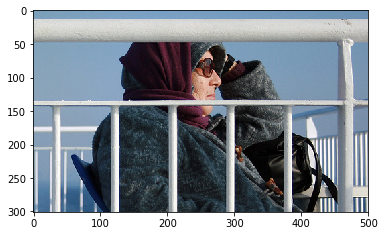

Eng  man is lying down on the top of some steps 
zh-TW 男人躺在一些步驟的頂部
Eng  black haired woman in grey sweater hangs from above white tshirt 
zh-TW 灰色毛衣的黑髮女人從白色t恤上面垂懸
No.2
(333, 500, 3)


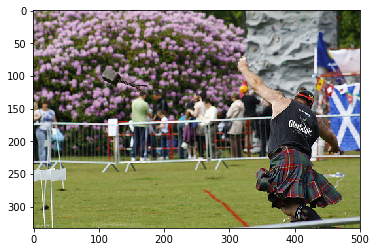

Eng  man in an athletic shirt is watching an unseen dog raises back on the shoulder of the ring 
zh-TW 穿著運動衫的男人正在看一隻看不見的狗在環的肩膀上升起
Eng  during martial arts game man is ready to kick the ball while group of people stand in the stands 
zh-TW 在武術比賽期間，一群人站在看台上時，人準備踢球
No.3
(375, 500, 3)


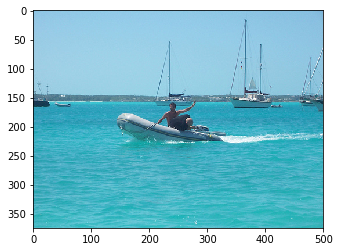

Eng  people are diving in the water with life are floating in the water 
zh-TW 人們在水中潛水，生活在水中漂浮
Eng  person in the middle of the pond is wearing black and white life jacket 
zh-TW 池塘中間的人穿著黑色和白色救生衣
No.4
(500, 357, 3)


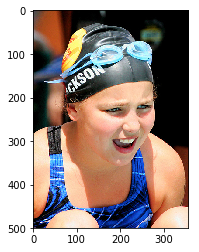

Eng  two smiling women in blue swimcap stand in group wearing wearing caps wings 
zh-TW 藍色泳帽的兩名微笑的婦女站立在佩帶佩帶的蓋帽翼的小組
Eng  man in blue speedo dancing 
zh-TW 藍色賽車跳舞的人
No.5
(400, 500, 3)


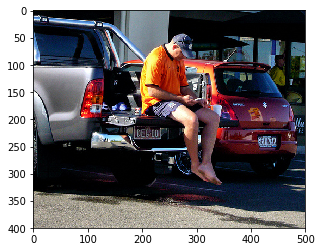

Eng  car is pulling down the road of an army vehicle 
zh-TW 汽車正在拉下軍車的路
Eng  man drives the car in the parking lot of old traffic vehicle 
zh-TW 男子開車在舊的交通車輛的停車場
No.6
(202, 500, 3)


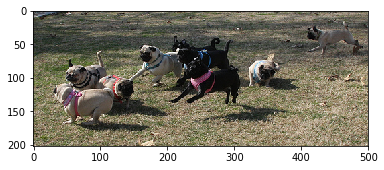

Eng  four black and black muzzled dogs are trying to run towards blue and white dog 
zh-TW 四隻黑色和黑色的被粘住的狗正試圖跑向藍色和白色的狗
Eng  five black and white and white dogs are chasing red red and white and dog 
zh-TW 五隻黑色和白色和白色的狗正在追逐紅色的紅色和白色和狗
No.7
(467, 500, 3)


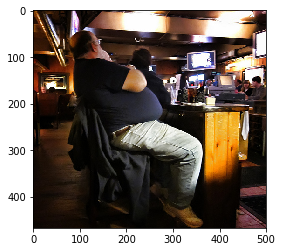

Eng  five people are lining up table at table 
zh-TW 五個人在桌旁排隊
Eng  five people are sitting at counter in round mirror that is sitting in store 
zh-TW 五個人坐在櫃檯上，坐在商店裡的圓形鏡子裡
No.8
(500, 333, 3)


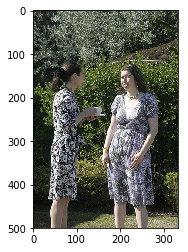

Eng  man and woman posing for picture in front of large tree 
zh-TW 男人和女人擺在大樹前的圖片
Eng  group of people posing for picture 
zh-TW 一群人擺姿勢為圖片
No.9
(400, 500, 3)


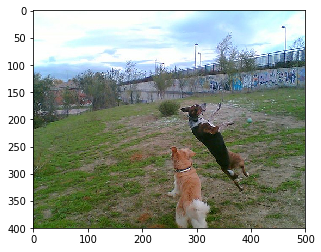

Eng  four dogs run in the fenced in grassy field 
zh-TW 四隻狗跑在圍欄草地裡
Eng  dog catches toy in the air 
zh-TW 狗在空中捕捉玩具
No.10
(500, 375, 3)


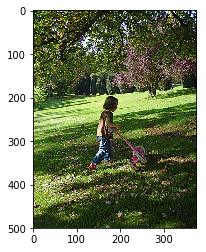

Eng  two little kids laugh at the playground 
zh-TW 兩個小孩嘲笑操場
Eng  little girl in dress shirt is playing with toy in field of playground 
zh-TW 禮服襯衫的小女孩玩在操場上的玩具
No.11
(500, 375, 3)


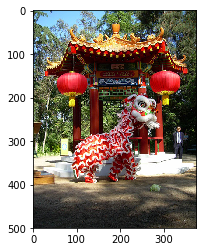

Eng  people are standing at lounge park 
zh-TW 人們正站在休息室公園
Eng  people are riding their outside of very long booth 
zh-TW 人們在非常長的展台外騎行
No.12
(500, 470, 3)


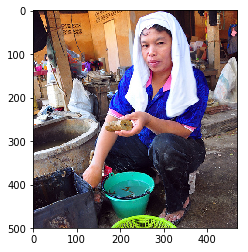

Eng  woman with white tshirt and dark pants sitting on the ground with spray of white rope 
zh-TW 女人與白色t恤和黑色的褲子坐在地上用白色繩子噴霧
Eng  man in white shirt sitting in the street filled with people in the background 
zh-TW 坐在街上的白色襯衫的男人充滿人在後台
No.13
(375, 500, 3)


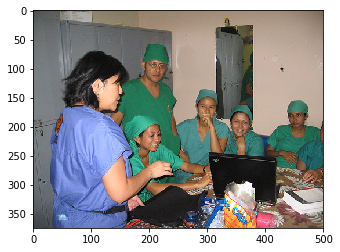

Eng  group of people sitting at table 
zh-TW 坐在桌上的一群人
Eng  group of people are sitting at table looking at photographs and pictures 
zh-TW 一群人坐在桌旁看著照片和照片
No.14
(333, 500, 3)


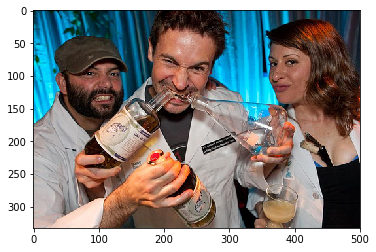

Eng  woman and boy are playing with fake bathroom in the bathroom 
zh-TW 女人和男孩在浴室裡玩假浴室
Eng  man and woman are using blue cup and getting fast 
zh-TW 男人和女人正在使用藍色杯子並且越來越快
No.15
(500, 333, 3)


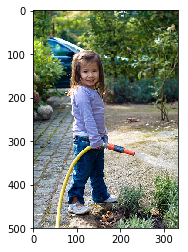

Eng  boy in blue shirt getting ready to jump on scooter in neighborhood neighborhood 
zh-TW 男孩穿著藍色襯衫準備跳上附近街區的滑板車
Eng  boy in blue shirt is riding his skateboard down the street 
zh-TW 穿著藍色襯衫的男孩騎著他的滑板在街上
No.16
(339, 500, 3)


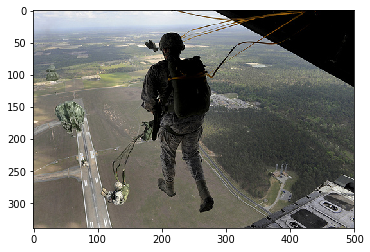

Eng  man is paddling in the water while being held by an airborne 
zh-TW 男子在空中舉行的同時在水中划槳
Eng  two people are riding their forest on the side of city street 
zh-TW 兩個人騎在城市街道旁邊的森林
No.17
(500, 375, 3)


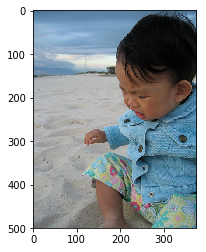

Eng  baby in white chair running at the beach 
zh-TW 寶貝在沙灘上跑步的白色椅子上
Eng  baby baby laughing by the beach on 
zh-TW 嬰兒寶寶在沙灘上笑
No.18
(500, 375, 3)


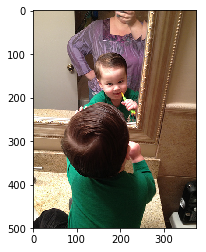

Eng  children look through the high high in the garden 
zh-TW 孩子們透過花園裡的高高在上
Eng  the children are hugging and are in the park with couple cheering 
zh-TW 孩子們正在擁抱，並在歡呼雀躍的公園裡
No.19
(335, 500, 3)


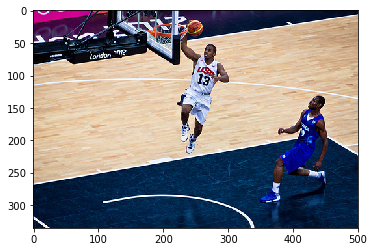

Eng  the player in the uniforms dribbles the ball while the player in the the two basketball looks on 
zh-TW 當兩名籃球運動員看上去時，制服中的球員會運球
Eng  the player in the uniforms dribbles the ball while the player in the orange tries to stop him 
zh-TW 當隊員身著橙色的球員試圖阻止他時，制服隊中的球員會跑球
No.20
(500, 500, 3)


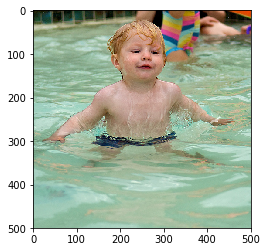

Eng  baby in pool held by boy swims 
zh-TW 男孩舉行的游泳池中的嬰兒游泳
Eng  baby in pool held by boy swims 
zh-TW 男孩舉行的游泳池中的嬰兒游泳
No.21
(375, 500, 3)


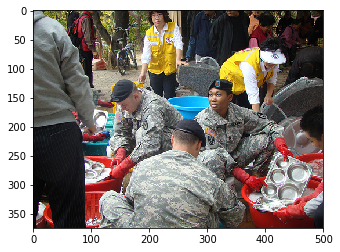

Eng  group of people gathering around parade float 
zh-TW 聚集在遊行浮游物附近的一群人
Eng  crowd of people some of which are wearing tan head 
zh-TW 其中一些人穿著棕褐色的頭
No.22
(500, 338, 3)


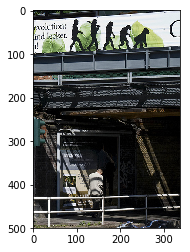

Eng  people are gathered on blue building in large building 
zh-TW 人們聚集在大樓的藍色建築中
Eng  people are staring at display fair with old buildings on deck 
zh-TW 人們正盯著甲板上陳舊的建築展覽會
No.23
(330, 500, 3)


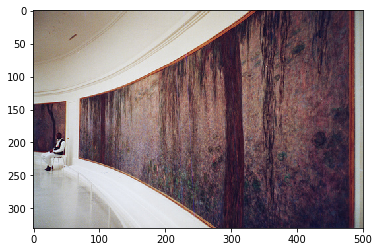

Eng  young boy in red shirt plays on the red colored 
zh-TW 紅色襯衫的年輕男孩扮演紅色
Eng  young boy in red shirt plays on the chair 
zh-TW 紅襯衫的年輕男孩在椅子上玩
No.24
(500, 499, 3)


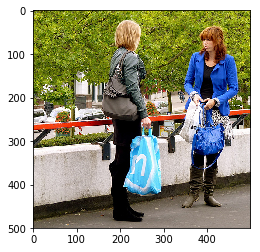

Eng  three children play with toy on paved walkway 
zh-TW 三個孩子在鋪設的走道上玩玩具
Eng  four boys are playing game gold fence and some flowers are outside 
zh-TW 四個男孩正在玩遊戲金柵欄，一些花在外面
No.25
(375, 500, 3)


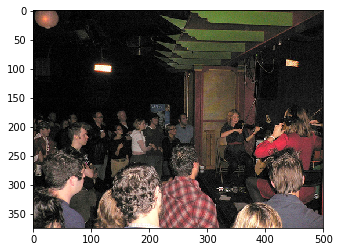

Eng  stadium full of people watch game 
zh-TW 充滿人的體育場觀看比賽
Eng  stadium full of people watch game 
zh-TW 充滿人的體育場觀看比賽
No.26
(500, 333, 3)


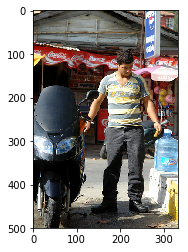

Eng  two people ride motorcycles 
zh-TW 兩個人騎摩托車
Eng  people ride an motorcycles vehicles 
zh-TW 人們騎摩托車
No.27
(474, 500, 3)


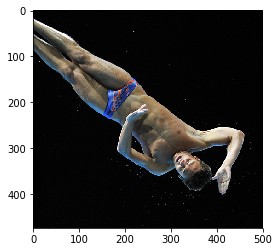

Eng  man jumps into swimming pool 
zh-TW 男子跳入游泳池
Eng  boy jumps over red and white sand at wrestling time 
zh-TW 男孩在摔跤時跳過紅色和白色沙灘
No.28
(375, 500, 3)


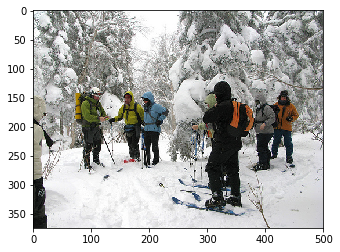

Eng  two people ice with their gear that has bitten an ice 
zh-TW 兩個人用咬著冰塊的裝備冰封
Eng  group of skiers climb snowy hill 
zh-TW 一群滑雪者爬上多雪的小山
No.29
(333, 500, 3)


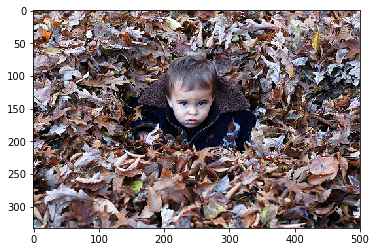

Eng  two young girls show hand 
zh-TW 兩個年輕女孩展示手
Eng  bunch of asian children are laughing on tree 
zh-TW 一群亞洲孩子在樹上笑
No.30
(500, 375, 3)


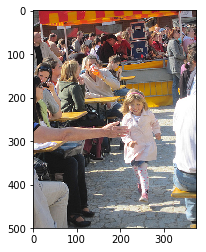

Eng  people sit on seats by pool 
zh-TW 人們通過游泳池坐在座位上
Eng  crowd of people are sitting in chairs 
zh-TW 人群坐在椅子上


In [18]:
import glob
piclst = glob.glob('data/Flickr30k/flickr30k_images/flickr30k_images/*.jpg')
ranpics = getrandom_fromlst(piclst, radnum=30)
#print(ranpics)
cn = 1
for fp in ranpics:
    print('No.%s' % cn)
    read_img_manview(fp)
    resize_image(fp, '/tmp/testvgg.jpg', rswidth=299, rsheight=299)
    ##不縮直接跑 
    photo = extract_features_onepic(fp)    
    generate_desc_transzhtw(model, tokenizer, photo, max_length)    
    ##縮圖跑
    photo = extract_features_onepic('/tmp/testvgg.jpg')    
    generate_desc_transzhtw(model, tokenizer, photo, max_length)
    cn += 1